# ch 12_6 tf-idf vectorizor 
이번 챕터에서는 scikit learn에 내장된 Tfidf 구현체를 이용하여 2022년 야구 뉴스 데이터 셋을 벡터로 표현해보겠습니다. 그리고 그 과정에서 사용되는 희소 행렬과 벡터 유사도의 개념을 익혀보겠습니다.

## 데이터 준비

미리 토큰화 해놓은 데이터를 읽어와서 명사만 집계해보겠습니다.

In [5]:
import pandas as pd

df = pd.read_csv("./data/baseball_title_tokens.csv")

In [8]:
df = df.dropna()

In [9]:
from tqdm import tqdm

tqdm.pandas()
df["title_tokens"] = df["title_tokens"].progress_apply(lambda x: eval(x))

100%|███████████████████████████████| 102479/102479 [00:05<00:00, 18181.74it/s]
/var/folders/wx/2vw1xwz972zdxff5h8gzrml00000gn/T/ipykernel_82474/593474298.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["title_tokens"] = df["title_tokens"].progress_apply(lambda x: eval(x))


In [11]:
def extract_nouns(content_tokens):
    return [text for text, tag in content_tokens if tag in ("NNP", "NNG")]

df["title_nouns"] = df["title_tokens"].progress_apply(lambda x: extract_nouns(x))

100%|██████████████████████████████| 102479/102479 [00:00<00:00, 428814.36it/s]
/var/folders/wx/2vw1xwz972zdxff5h8gzrml00000gn/T/ipykernel_82474/3281825623.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["title_nouns"] = df["title_tokens"].progress_apply(lambda x: extract_nouns(x))


In [12]:
df

,title,title_tokens,title_nouns
0,"KBO 역대급 외인타자, 끝내 10개 구단 외면 받고 사라지나","[(KBO, NNP), (역대, NNG), (급, NNG), (외, NNB), (이...","[KBO, 역대, 급, 타자, 구단, 외면]"
1,'불혹의 거인’ 침묵이 심상찮다...'꿈'이 영원히 사라지고 있는데...,"[(', SS), (불혹, NNG), (의, JKG), (거인, NNP), (’, ...","[불혹, 거인, 침묵, 꿈]"
2,"'롯데맨'으로 새해 맞은 문경찬 ""불펜 경쟁서 살아남겠다"" [MK인터뷰]","[(', SS), (롯데, NNP), (맨, NNP), (', SS), (으로, J...","[롯데, 맨, 새해, 문경, 불펜, 경쟁, 인터뷰]"
3,"'유일한 FA 미계약자' 정훈 결국 해 넘겼다, 롯데 ""이견 좁혀가는 중""","[(', SS), (유일한, NNP), (FA, SL), (미, NNP), (계약자...","[유일한, 미, 계약자, 정훈, 롯데, 이견]"
4,"""KIA 5강 이상, SSG 알찬 보강, NC 구창모 오면…"" 허구연 위원 픽, 2...","[("", SS), (KIA, NNP), (5, SN), (강, NNP), (이상, ...","[KIA, 강, 이상, SSG, 보강, NC, 구창모, 허구연, 위원, 주목, 팀]"
...,...,...,...
102477,"‘위기의 남자’ 김동엽, 박진만 감독은 대행 시절 “쓰지 않겠다”고 했다","[(‘, SS), (위기의 남자, NNP), (’, SS), (김동엽, NNP), ...","[위기의 남자, 김동엽, 박진만, 감독, 대행, 시절]"
102478,'21년 대타 타율 .371' 결국 은퇴를 선언한 前 두산 포수 최용제,"[(', SS), (21년, NNP), (대타, NNP), (타율, NNP), (....","[21년, 대타, 타율, 은퇴, 선언, 두산, 포수, 최용]"
102479,"“스트레스 받는 성격 아닌데…” KIA 캡틴의 진심, 이적생 3루수에게 고맙다","[(“, SS), (스트레스, NNP), (받, VV), (는, ETM), (성격,...","[스트레스, 성격, KIA, 캡틴, 진심, 3루수]"
102480,'호주에서도 못 잡으면…' 드래프트 전체 1순위 국대 출신 좌완 파이어볼러 깊어지는 고민,"[(', SS), (호주, NNP), (에서, JKB), (도, JX), (못, M...","[호주, 드래프트, 전체, 순위, 국, 출신, 좌완, 파이어볼, 러, 고민]"


## scikit-learn TfidfVectorizer
scikit-learn에 내장된 TfidfVectorizer를 사용해보겠습니다. 미리 토큰화와 전처리를 해놓았기 때문에 tokenizer와 preprocessor에 dummy_fun을 전달하겠습니다.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer="word",
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None
)

명사 리스트만 전달하여 tf-idf vectorizor를 학습시켜 보겠습니다. 

In [16]:
tfidf_csr_matrix = tfidf.fit_transform(df["title_nouns"])

In [18]:
tfidf_csr_matrix, type(tfidf_csr_matrix)

(<102479x14889 sparse matrix of type '<class 'numpy.float64'>'
 	with 773059 stored elements in Compressed Sparse Row format>,
 scipy.sparse._csr.csr_matrix)

## CSR matrix
자, tf-idf 알고리즘을 학습시킨 뒤, 기사 하나를 tf-idf로 변환하면 CSR_matrix라는 것이 리턴됩니다. 이를 번역하면 압축된 희소 행렬이라는 개념입니다. 이는 희소 행렬을 효율적으로 표현한 자료구조입니다.

기사 제목에 쓰인 단어의 수는 무척 많습니다. 반면에 하나의 기사 제목에 포함된 단어의 수는 적습니다. 이를 일반 list나 ndarray로 표현하게 될 경우, 쓸모없는 0 값이 많이 포함됩니다.

In [19]:
tfidf_vector_list = tfidf_csr_matrix.toarray()

In [23]:
sample = tfidf_vector_list[0]
sample

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
print("0이 아닌 원소 개수:", len(sample[sample != 0]))
print("0인 원소 개수:", len(sample[sample == 0]))

0이 아닌 원소 개수: 6
0인 원소 개수: 14883


이렇게 실질적인 값의 개수가 전체 차원에 비해 현저하게 적은 것을 sparse하다고 표현합니다. 0 값들을 직접 저장하지 않고, 실제 값들이 들어있는 index와 value만 저장하면 훨씬 효율적이겠죠? 이를 지원하는 것이 scipy의 compressed sparse matrix입니다.

In [31]:
print(df.iloc[0]["title_nouns"])
print(tfidf_csr_matrix[0])

['KBO', '역대', '급', '타자', '구단', '외면']
  (0, 9104)	0.5832708422962386
  (0, 1778)	0.40118600558969275
  (0, 13033)	0.30843914447491494
  (0, 2102)	0.43248008730260834
  (0, 8599)	0.3834463399376442
  (0, 541)	0.2638940811703792


compressed sparse matrix를 살펴보면 각 단어의 인덱스와 tf-idf 스코어 값이 들어있습니다. 이를 이용해서 차원이 아무리 크더라도 메모리를 효율적으로 사용할 수 있습니다.

## TF-IDF를 이용한 문장 벡터화

사전에 학습한 문장 이외에 새로운 문장이 들어왔을 때, 이를 벡터로 변환해보겠습니다.

In [32]:
from konlpy.tag import Komoran

komoran = Komoran(userdic="./data/user.dic")

In [33]:
def extract_nouns(text):
    tokens = komoran.pos(text)
    nouns = [text for text, tag in tokens if tag in ("NNP", "NNG")]
    return nouns

In [34]:
query = "이정후 선수가 SSG와의 경기에서 연타석 홈런을 터뜨렸습니다."

In [35]:
query_nouns = extract_nouns(query)
print(query_nouns)

['이정후', '선수', 'SSG', '경기', '연', '타석', '홈런']


In [39]:
query_csr_matrix = tfidf.transform([query_nouns])

## 벡터 유사도 비교

벡터들 간에는 서로 유사도를 비교할 수 있습니다. 그 중에서 가장 많이 사용되는 것은 코사인 유사도입니다. 코사인 유사도는 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도를 의미합니다. 

두 벡터의 방향이 완전히 동일한 경우에는 1의 값을 가지며, 90°의 각을 이루면 0, 180°로 반대의 방향을 가지면 -1의 값을 갖게 됩니다. 즉, 결국 코사인 유사도는 -1 이상 1 이하의 값을 가지며 값이 1에 가까울수록 유사도가 높다고 판단할 수 있습니다. 이를 직관적으로 이해하면 두 벡터가 가리키는 방향이 얼마나 유사한가를 의미합니다.

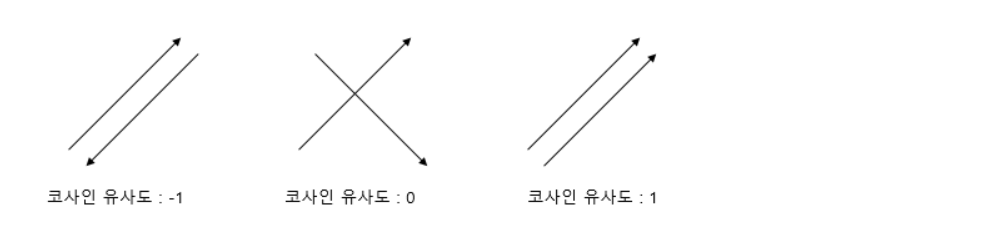

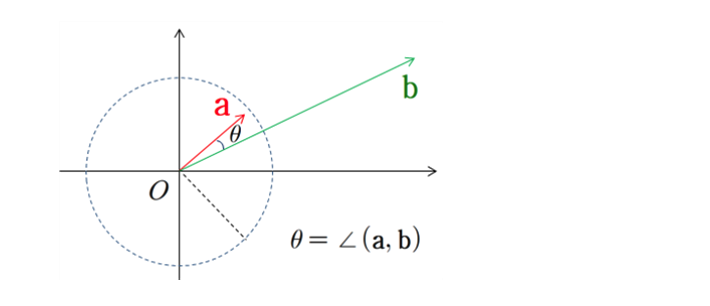

이를 수식으로 나타내면 아래와 같습니다. 코사인 제 2 법칙을 이용해서 유도합니다. 수식은 잘 모르셔도 무방합니다. 벡터간의 유사도는 코사인 유사도를 사용한다 정도만 이해하고 넘어가면 됩니다.


$$similarity=cos(Θ)=\frac{A⋅B}{||A||\ ||B||}=\frac{\sum_{i=1}^{n}{A_{i}×B_{i}}}{\sqrt{\sum_{i=1}^{n}(A_{i})^2}×\sqrt{\sum_{i=1}^{n}(B_{i})^2}}$$

## TF-IDF를 이용한 검색

검색 쿼리를 백터화하고, 기존 문서들과의 유사도를 비교해서 가장 유사한 문장을 찾아서 리턴하면 검색을 구현할 수 있습니다.

In [67]:
from sklearn.metrics.pairwise import cosine_similarity

def tfidf_search(query, k=5):
    # tfidf를 이용하여 query를 벡터로 변환
    query_nouns = extract_nouns(query)
    query_csr_matrix = tfidf.transform([query_nouns])
    
    # consine similarity 측정하고, 가장 유사한 top k 문서 찾음
    similarites = cosine_similarity(query_csr_matrix, tfidf_csr_matrix).flatten()
    top_similarities = sorted(similarites, reverse=True)[:k]
    top_indices = similarites.argsort()[-k:][::-1]
    top_titles = [df.iloc[i]["title"] for i in top_indices]
    
    # 결과 출력
    for top_title, top_similarity in zip(top_titles, top_similarities):
        print(round(top_similarity, 4), top_title)

In [70]:
query = "WBC 한국"
tfidf_search(query=query)

0.6861 한국-일본 프로야구 WBC에서 14년 만에 만난다
0.6724 ‘한국계 MLB’ 에드먼, 내년 한국 WBC 대표로 나서나
0.6593 MLB 100년 만에 한국 온다
0.6303 이강철 감독, 2023 WBC 한국 야구대표팀 이끈다
0.6261 WBC 한국 대표팀 사령탑에 이강철


## 정리

이번 챕터에서는 대표적인 빈도수 기반의 NLP 알고리즘인 tf-idf에 대해서 배워보았습니다. tf-idf는 직관적이고 가볍기 때문에 실무에서도 종종 쓰이는 기법입니다. 특히 자연어 기반의 간단한 추천 시스템을 구현하는데 사용됩니다.

또한 벡터 간에 코사인 유사도를 계산하여 간단한 검색 엔진을 구현해 보았습니다. 벡터 유사도 계산은 AI 기반 시스템에서 정말 많이 사용하므로, 꼭 기억하시기 바랍니다. 